# BFAST Monitor Example Notebook

This notebook demonstrates the usage of the `bfast` package for monitoring changes in time series data, specifically using the **BFAST Monitor** algorithm.

We will use a small dataset from Peru (`peru_small`) to detect breaks in vegetation indices (or similar time series data).

## 1. Import Packages

First, we import the necessary Python libraries.

In [8]:
import os
import wget
import time
import copy
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from bfast import BFASTMonitor
from bfast.monitor.utils import crop_data_dates

## 2. Download and Load Data

We check if the sample data is available locally. If not, we download it. The dataset consists of a 3D numpy array (`data.npy`) representing the image time series and a text file (`dates.txt`) containing the dates for each slice.

In [10]:
# Define paths
data_dir = "../data/peru_small"
ifile_meta = os.path.join(data_dir, "dates.txt")
ifile_data = os.path.join(data_dir, "data.npy")

# Create directory if it doesn't exist
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

# Download metadata if missing
if not os.path.exists(ifile_meta):
    print("Downloading dates.txt...")
    url = 'https://sid.erda.dk/share_redirect/fcwjD77gUY/dates.txt'
    wget.download(url, ifile_meta)

# Download data if missing
if not os.path.exists(ifile_data):
    print("Downloading data.npy...")
    url = 'https://sid.erda.dk/share_redirect/fcwjD77gUY/data.npy'
    wget.download(url, ifile_data)

print("Data ready.")

Data ready.


Now we load the data into memory and parse the dates.

In [11]:
data_orig = np.load(ifile_data)
with open(ifile_meta) as f:
    dates_str = f.read().split('\n')
    dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates_str if len(d) > 0]

## 3. Configuration and Preprocessing

We define the parameters for the BFAST Monitor algorithm:
- `k`: Number of harmonic terms.
- `freq`: Frequency of the seasonal model (365 for daily data).
- `start_hist`: Start of the history period.
- `start_monitor`: Start of the monitoring period.
- `end_monitor`: End of the monitoring period.

In [12]:
# Parameters
k = 3
freq = 365
trend = False
hfrac = 0.25
level = 0.05

start_hist = datetime(2002, 1, 1)
start_monitor = datetime(2010, 1, 1)
end_monitor = datetime(2018, 1, 1)

# Crop data to the specified date range
data, dates = crop_data_dates(data_orig, dates, start_hist, end_monitor)

print("First date: {}".format(dates[0]))
print("Last date: {}".format(dates[-1]))
print("Shape of data array: {}".format(data.shape))

First date: 2003-07-14 00:00:00
Last date: 2016-09-27 00:00:00
Shape of data array: (216, 334, 334)


## 4. Initialize and Fit the Model (Python Backend)

We initialize the `BFASTMonitor` with the `backend='python'`. This allows the code to run on standard CPUs without needing OpenCL drivers or a GPU. For faster processing on supported hardware, you can change the backend to `'opencl'`.

In [14]:
model = BFASTMonitor(
    start_monitor,
    freq=freq,
    k=k,
    hfrac=hfrac,
    trend=trend,
    level=level,
    backend='python',  # Use 'python-mp' for multiprocessing or 'opencl' for GPU
    verbose=0 # Use 1 for more detail
)

print("Starting model fit...")
start_time = time.time()

# Fit the model
# nan_value specifies the integer value in the input that represents NaN (e.g. -32768)
model.fit(data, dates, n_chunks=5, nan_value=-32768)

end_time = time.time()
print("All computations have taken {:.2f} seconds.".format(end_time - start_time))

Starting model fit...
All computations have taken 41.45 seconds.


## 5. Visualizing the Results

After fitting, we can extract the results:
- `breaks`: Index of the detected break (or -1 if none, -2 if insufficient data).
- `means`: Mean values of the MOSUM process.

We will visualize the time of the first detected break.

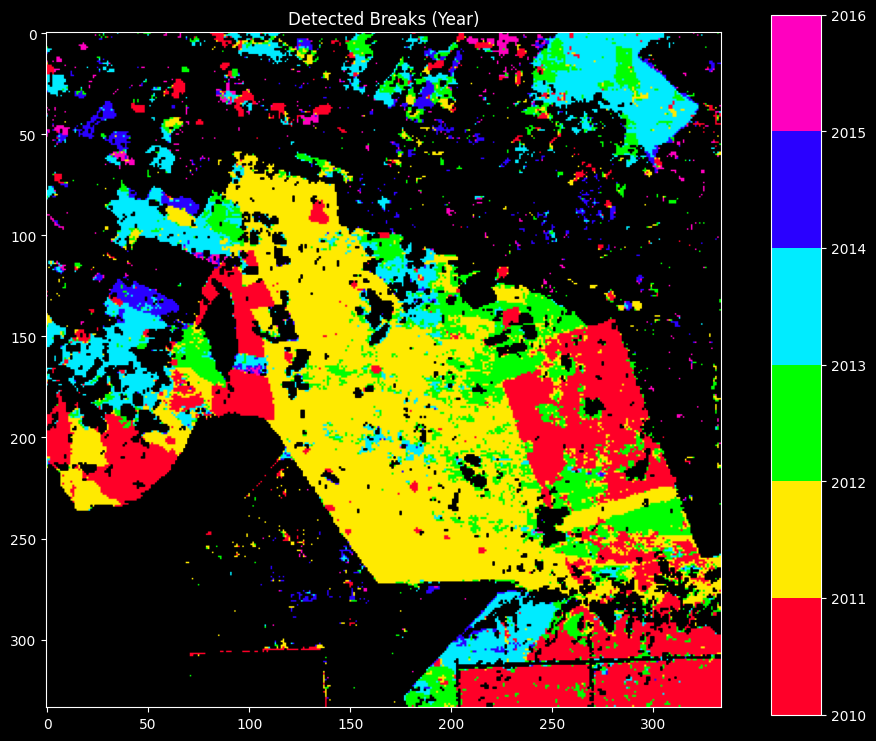

In [16]:
breaks = model.breaks
means = model.means

# Process breaks for plotting
breaks_plot = breaks.astype(float)
breaks_plot[breaks == -2] = np.nan # Insufficient data
breaks_plot[breaks == -1] = np.nan # No break detected
breaks_plot[means >= 0] = np.nan   # Filter out positive means (greening) if interested in degradation

# Map break indices to years for better visualization
dates_monitor = [d for d in dates if start_monitor <= d]
dates_array = np.array(dates_monitor)

# Helper to find start indices of years
def get_year_idx(year):
    return np.argmax((dates_array >= datetime(year, 1, 1)))

idx_start_2010 = get_year_idx(2010)
idx_start_2011 = get_year_idx(2011)
idx_start_2012 = get_year_idx(2012)
idx_start_2013 = get_year_idx(2013)
idx_start_2014 = get_year_idx(2014)
idx_start_2015 = get_year_idx(2015)
idx_start_2016 = get_year_idx(2016)

breaks_plot_years = copy.deepcopy(breaks_plot)

# Bin breaks by year
breaks_plot_years[breaks_plot <= idx_start_2011] = 0
breaks_plot_years[np.where((idx_start_2011 < breaks_plot) & (breaks_plot <= idx_start_2012))] = 1
breaks_plot_years[np.where((idx_start_2012 < breaks_plot) & (breaks_plot <= idx_start_2013))] = 2
breaks_plot_years[np.where((idx_start_2013 < breaks_plot) & (breaks_plot <= idx_start_2014))] = 3
breaks_plot_years[np.where((idx_start_2014 < breaks_plot) & (breaks_plot <= idx_start_2015))] = 4
breaks_plot_years[np.where((idx_start_2015 < breaks_plot) & (breaks_plot <= idx_start_2016))] = 5
breaks_plot_years[np.where(idx_start_2016 < breaks_plot)] = 6

# Create colormap
cmap = plt.get_cmap("gist_rainbow")
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0, 6, 7)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
im = axes.imshow(breaks_plot_years, cmap=cmap, norm=norm)
axes.set_title("Detected Breaks (Year)")

# Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0, 1, 2, 3, 4, 5, 6])
cbar.ax.set_yticklabels(['2010', '2011', '2012', '2013', '2014', '2015', '2016'])

plt.show()

## 6. Using the OpenCL Backend (GPU)

If you have a GPU and configured OpenCL drivers (PyOpenCL), you can significantly speed up the computations. Below is the code to run the same analysis using the `opencl` backend.

In [ ]:
# OpenCL Backend Example (Requires GPU)
try:
    import pyopencl
    print("PyOpenCL available. Attempting to use OpenCL backend...")
    
    model_ocl = BFASTMonitor(
        start_monitor,
        freq=freq,
        k=k,
        hfrac=hfrac,
        trend=trend,
        level=level,
        backend='opencl', # Use OpenCL backend
        device_id=0,
        verbose=1
    )
    
    start_time = time.time()
    model_ocl.fit(data, dates, n_chunks=5, nan_value=-32768)
    end_time = time.time()
    print("OpenCL computations have taken {:.2f} seconds.".format(end_time - start_time))
    
except Exception as e:
    print(f"OpenCL execution failed or not available: {e}")